# Land Use Classification with Tensorflow

<a name="prep"></a>
## Prepare deep learning framework-specific input files

If you have not generated your own training and validation sets through image extraction, download the following files and decompress them in your VM's temporary (`D:\`) storage:
- [Balanced training image set (~3 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_training_set.zip)
- [Balanced validation image set (~1 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_validation_set.zip)

The image sets linked above contain raw PNG images sorted into folders by their assigned label. Many deep learning frameworks require proprietary image formats or supporting files to efficiently load images in minibatches for training. We now produce the supporting files needed by our CNTK and TensorFlow training scripts. Note that we do not need to produce similar supporting files for the validation image set, because we will not use minibatching when applying the trained models to the validation set.

Update the `training_image_dir` variable below to reflect the directory where your training and validation sets have been saved. The `label_to_number_dict` variable specifies the correspondence between the label names and a numeric code; it does not need to be modified unless you have changed the labeling scheme.

In [15]:
import os, sys
import urllib.request
import tarfile
import numpy as np
import pandas as pd
import tensorflow as tflow
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, accuracy_score

import utils.connection_settings as cs
import utils.land_use_classification_utils as luc

# Change this directory to point to the location where you downloaded or cloned this git repo
repo_dir = 'C:\\Users\\t-tyrome\\Documents\\Internship\\LandUseClassification'

training_image_dir = cs.TRAINING_IMAGE_DIR
validation_image_dir = cs.VALIDATION_IMAGE_DIR
test_image_dir = cs.TEST_IMAGE_DIR
label_to_number_dict = {'Barren': 0,
                        'Forest': 1,
                        'Shrub': 2,
                        'Cultivated': 3,
                        'Herbaceous': 4,
                        'Developed': 5}

def get_nlcd_id(my_filename):
    ''' Extracts the true label  '''
    folder, _ = os.path.split(my_filename)
    return(label_to_number_dict[os.path.basename(folder)])

# Autoreload when modules are changed
%load_ext autoreload
%autoreload 2

# Show matplotlib plots inline
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a name="tf"></a>
### TensorFlow

We made use of the [`tf-slim` API](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) for TensorFlow, which provides pre-trained ResNet models and helpful scripts for retraining and scoring. These scripts require converting the image set into [TFRecords](https://www.tensorflow.org/how_tos/reading_data/#file_formats) for minibatching. (Each TFRecord contains many image files as well as their labels.) We also create a `labels.txt` file mapping the labels to integer values, and a `dataset_split_info.csv` file describing the images assigned to the training set.

The following code was modified from the [TensorFlow models repo's slim subdirectory](https://github.com/tensorflow/models/tree/master/slim).

In [2]:
# Original Copyright 2016 The TensorFlow Authors. All Rights Reserved.
# Modified 2017 by Microsoft Corporation.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
np.random.seed(5318)

class ImageReader(object):
    def __init__(self):
        # Initializes function that decodes RGB JPEG data.
        self._decode_png_data = tflow.placeholder(dtype=tflow.string)
        self._decode_png = tflow.image.decode_png(self._decode_png_data, channels=3)

    def read_image_dims(self, sess, image_data):
        image = self.decode_png(sess, image_data)
        return image.shape[0], image.shape[1]

    def decode_png(self, sess, image_data):
        image = sess.run(self._decode_png,
                         feed_dict={self._decode_png_data: image_data})
        assert len(image.shape) == 3
        assert image.shape[2] == 3
        return image
    
def image_to_tfexample(image_data, image_format, height, width, class_id):
    return tflow.train.Example(features=tflow.train.Features(feature={
        'image/encoded': tflow.train.Feature(bytes_list=tflow.train.BytesList(value=[image_data])),
        'image/format': tflow.train.Feature(bytes_list=tflow.train.BytesList(value=[image_format])),
        'image/class/label': tflow.train.Feature(int64_list=tflow.train.Int64List(value=[class_id])),
        'image/height': tflow.train.Feature(int64_list=tflow.train.Int64List(value=[height])),
        'image/width': tflow.train.Feature(int64_list=tflow.train.Int64List(value=[width])),
    }))

def find_images(image_dir):
    training_filenames = []
    for folder in os.listdir(image_dir):
        folder_path = os.path.join(image_dir, folder)
        if not os.path.isdir(folder_path):
            continue
        ''' This is a new directory/label -- consider all images inside it '''
        my_filenames = []
        for filename in os.listdir(folder_path):
            my_filenames.append(os.path.join(folder_path, filename))
        training_filenames.extend(my_filenames)
    print('Found {} training images'.format(len(training_filenames)))
    return(training_filenames)
    
def write_dataset(dataset_name, split_name, my_filenames,  image_dir, n_shards=5):
    num_per_shard = int(np.ceil(len(my_filenames) / n_shards))
    records = []
    with tflow.Graph().as_default():
        image_reader = ImageReader()
        with tflow.Session('') as sess:
            for shard_idx in range(n_shards):
                shard_filename = os.path.join(image_dir,
                                              '{}_{}_{:05d}-of-{:05d}.tfrecord'.format(dataset_name,
                                                                                       split_name,
                                                                                       shard_idx+1,
                                                                                       n_shards))
                with tflow.python_io.TFRecordWriter(shard_filename) as tfrecord_writer:
                    for image_idx in range(num_per_shard * shard_idx,
                                           min(num_per_shard * (shard_idx+1), len(my_filenames))):
                        with open(my_filenames[image_idx], 'rb') as f:
                            image_data = f.read()
                        height, width = image_reader.read_image_dims(sess, image_data)
                        class_name = os.path.basename(os.path.dirname(my_filenames[image_idx]))
                        class_id = label_to_number_dict[class_name]
                        example = image_to_tfexample(image_data, b'png', height, width, class_id)
                        tfrecord_writer.write(example.SerializeToString())
                        records.append([dataset_name, split_name, my_filenames[image_idx], shard_idx,
                                        image_idx, class_name, class_id])
    df = pd.DataFrame(records, columns=['dataset_name', 'split_name', 'filename', 'shard_idx', 'image_idx',
                                        'class_name', 'class_id'])
    return(df)
 
training_filenames = find_images(training_image_dir)
training_filenames = np.random.permutation(training_filenames)
df = write_dataset('aerial', 'train', training_filenames, training_image_dir, n_shards=50)
df.to_csv(os.path.join(training_image_dir, 'dataset_split_info.csv'), index=False)

with open(os.path.join(training_image_dir, 'labels.txt'), 'w') as f:
    for key, value in label_to_number_dict.items():
        f.write('{}:{}\n'.format(key, value))
        
print("Done")

Found 44184 training images


<a name="tensorflow"></a>
## Retrain a pretrained ResNet with TensorFlow

We made use of the [`tf-slim` API](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/slim) for TensorFlow, which provides pre-trained ResNet models and helpful scripts for retraining and scoring. During training set preparation, we created the [TFRecords](https://www.tensorflow.org/how_tos/reading_data/#file_formats) that the training script will use as input. For more details on the training data, please see the image preparation notebook in the [Embarrassingly Parallel Image Classification](https://github.com/Azure/Embarrassingly-Parallel-Image-Classification) repository. 

Our retraining script, `retrain.py` in the `tf` folder of [this repository](https://github.com/Azure/Embarrassingly-Parallel-Image-Classification), is a modified version of `train_image_classifier.py` from the [TensorFlow models repo's slim subdirectory](https://github.com/tensorflow/models/tree/master/slim).

<a name="tfmodel"></a>
### Download a pretrained model

We obtained a 50-layer ResNet pretrained on ImageNet from a link in the [TensorFlow models repo's slim subdirectory](https://github.com/tensorflow/models/tree/master/slim). The pretrained model can be obtained and unpacked with the code snippet below. Note that if you have not already done so, you will first need to [download or clone this repo](https://github.com/Azure/Embarrassingly-Parallel-Image-Classification), then update the variable name `repo_dir` below to point to the repo's root folder.

In [ ]:
os.makedirs(os.path.join(repo_dir, 'tf'))
urllib.request.urlretrieve('http://download.tensorflow.org/models/resnet_v1_50_2016_08_28.tar.gz',
                           os.path.join(repo_dir, 'tf', 'resnet_v1_50_2016_08_28.tar.gz'))
with tarfile.open(os.path.join(repo_dir, 'tf', 'resnet_v1_50_2016_08_28.tar.gz'), 'r:gz') as f:
    f.extractall(path=os.path.join(repo_dir, 'tf'))
os.remove(os.path.join(repo_dir, 'tf', 'resnet_v1_50_2016_08_28.tar.gz'))

<a name="tfrun"></a>
## Retrain the Model

We recommend that you run the training script from an Anaconda prompt. The code cell below will help you generate the appropriate command based on your file locations.

In [3]:
# path where retrained model and logs will be saved during training
train_dir = os.path.join(repo_dir, 'tf', 'models')
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
    
# location of the unpacked pretrained model
checkpoint_path = os.path.join(repo_dir, 'tf', 'resnet_v1_50.ckpt')

command = '''python {0} --train_dir={1} --dataset_name=aerial --dataset_split_name=train --dataset_dir={2} --checkpoint_path={3}
'''.format(os.path.join(repo_dir, 'tf', 'retrain.py'),
           train_dir,
           training_image_dir,
           checkpoint_path)

print(command)

python C:\Users\t-tyrome\Documents\Internship\LandUseClassification\tf\retrain.py --train_dir=C:\Users\t-tyrome\Documents\Internship\LandUseClassification\tf\models --dataset_name=aerial --dataset_split_name=train --dataset_dir=C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_training_set --checkpoint_path=C:\Users\t-tyrome\Documents\Internship\LandUseClassification\tf\resnet_v1_50.ckpt



## Score on the Validation Set

In [12]:
import functools
from scipy import misc
import glob
import tf.nets.resnet_v1 as resnet_v1
slim = tflow.contrib.slim

In [18]:
def get_network_fn(num_classes, weight_decay=0.0, is_training=False):
    arg_scope = resnet_v1.resnet_arg_scope(weight_decay=weight_decay)
    func = resnet_v1.resnet_v1_50
    @functools.wraps(func)
    def network_fn(images):
        with slim.arg_scope(arg_scope):
            return func(images, num_classes, is_training=is_training)
    if hasattr(func, 'default_image_size'):
        network_fn.default_image_size = func.default_image_size
    return(network_fn)

def mean_image_subtraction(image, means):
    num_channels = image.get_shape().as_list()[-1]
    channels = tflow.split(image, num_channels, 2)
    for i in range(num_channels):
        channels[i] -= means[i]
    return(tflow.concat(channels, 2))

def get_preprocessing():
    def preprocessing_fn(image, output_height=224, output_width=224):
        image = tflow.expand_dims(image, 0)
        resized_image = tflow.image.resize_bilinear(image, [output_height, output_width], align_corners=False)
        resized_image = tflow.squeeze(resized_image)
        resized_image.set_shape([output_height, output_width, 3])
        image = tflow.to_float(resized_image)
        return(mean_image_subtraction(image, [123.68, 116.78, 103.94]))
    return(preprocessing_fn)


def score_model(file_list):
    model_dir = 'C:\\Users\\t-tyrome\\Documents\\Internship\\LandUseClassification\\tf\\models'
    results = []
    
    with tflow.Graph().as_default():
        network_fn = get_network_fn(num_classes=6, is_training=False)
        image_preprocessing_fn = get_preprocessing()
        
        current_image = tflow.placeholder(tflow.uint8, shape=(224, 224, 3))
        preprocessed_image = image_preprocessing_fn(current_image, 224, 224)
        image  = tflow.expand_dims(preprocessed_image, 0)
        logits, _ = network_fn(image)
        predictions = tflow.argmax(logits, 1)
        
        with tflow.Session() as sess:
            my_saver = tflow.train.Saver()
            my_saver.restore(sess, tflow.train.latest_checkpoint(model_dir))
            
            for file in file_list:
                #imported_image_np = np.asarray(Image.open(BytesIO(file[1])), dtype=np.uint8)
                imported_image_np = misc.imread(file)
                result = sess.run(predictions, feed_dict={current_image: imported_image_np})
                true_label = get_nlcd_id(file)
                results.append([file, true_label, result[0]])

    return(results)

In [19]:
#labeled_images_tf = image_rdd.mapPartitions(tf_run_worker)
dataset_dir = 'C:\\Users\\t-tyrome\\Documents\\Internship\\LandUseClassification\\data\\balanced_validation_set'
file_list = glob.glob('{}/*/*.png'.format(dataset_dir))
#print(file_list)

start = pd.datetime.now()
#results_tf = labeled_images_tf.collect()
results_tf = score_model(file_list)
print('Scored {} images'.format(len(results_tf)))
stop = pd.datetime.now()
print(stop - start)

INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Scale of 0 disables regularizer.


INFO:tensorflow:Restoring parameters from C:\Users\t-tyrome\Documents\Internship\LandUseClassification\tf\models\model.ckpt-4000


INFO:tensorflow:Restoring parameters from C:\Users\t-tyrome\Documents\Internship\LandUseClassification\tf\models\model.ckpt-4000


C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_13449.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_13652.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_15060.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_15064.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_15483.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_15693.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_25892.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_26029.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_26058.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_26179.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_26194.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_26359.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_28601.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_28602.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_28839.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_29039.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_29047.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_29071.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_32496.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_32518.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_32550.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_32565.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_32741.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_32744.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_35440.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_35452.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_35455.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_35456.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_35751.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_35752.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_38677.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_38684.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_38689.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_38708.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_38720.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_38890.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_41308.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_41504.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_41505.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_41508.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_41543.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_41756.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_45382.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_45568.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_45569.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_45570.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_45583.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_45584.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_49962.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_49969.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_49970.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_49985.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_50183.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_50189.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_55367.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_55382.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_55394.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_55398.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_55598.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_55600.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_58896.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_58922.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_58957.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_59131.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_59133.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_59177.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_61711.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_61870.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_61893.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_61897.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_61926.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_62100.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_64572.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_64608.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_64611.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_64631.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_64801.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_64829.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_67215.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_67236.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_67238.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_67246.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_67258.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_67397.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_69486.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_69499.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_69526.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_69529.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_69534.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_69554.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_72232.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_72239.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_72250.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_72261.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_72262.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_72452.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_75453.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_75464.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_75466.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_75600.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_75639.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_75645.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_80533.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_80549.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_80562.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_80814.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_81049.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1_hn_s_ca073_2016_1_81067.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Barren\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ca073_2016_1_75310.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ca073_2016_1_75526.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ca073_2016_1_76008.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ca073_2016_1_76010.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ca073_2016_1_76134.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ca073_2016_1_77033.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_11136.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_11203.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_11218.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_11222.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_11296.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_11324.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_13544.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_13564.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_13568.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_13622.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_13644.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_1368.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validati

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_1510.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_15139.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_15142.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_15177.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_15193.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_15266.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validati

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_1779.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_17801.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_17808.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_1782.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_17830.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_17835.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validatio

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_1925.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_19288.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_19339.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_19363.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_1941.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_19434.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validatio

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_20399.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_20411.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_20421.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_20426.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_20429.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_20485.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_21854.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_21858.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_21873.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_21882.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_21892.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_21987.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_23272.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_23273.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_23276.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_23287.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_23292.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_23332.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_24580.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_24630.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_2469.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_24728.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_24737.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_24768.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validati

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_25973.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_26017.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_26091.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_26125.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_26144.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_26148.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_2793.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_2794.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_27948.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_27964.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_27989.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_28070.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validatio

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_30282.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_30283.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_30293.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_30375.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_30380.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_30395.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_3273.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_3286.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_3297.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_3321.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_3331.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_3411.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_4643.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_4647.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_4649.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_4677.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_4696.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_4744.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_5886.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_5888.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_5896.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_5941.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_5942.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_5987.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_725.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_7288.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_7290.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_7330.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_7412.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_7413.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_8399.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_8441.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_848.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_8503.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_8523.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Cultivated\ortho_1-1_hn_s_ne003_2016_1_8615.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_10025.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_10233.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_10439.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_10451.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_10453.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_10675.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_13491.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_13494.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_13676.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_13677.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_13686.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_13687.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_15928.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_15929.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_15931.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_16118.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_16119.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_16121.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_17438.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_17439.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_17443.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_17444.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_17445.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_17446.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_20237.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_20238.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_20239.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_20240.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_20241.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_2043.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_22305.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_22307.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_22308.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_22309.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_22310.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_22312.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_23793.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_23794.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_23796.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_23797.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_23798.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_23960.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_25509.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_25510.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_25511.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_25512.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_25513.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_25514.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_27991.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_2803.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_28187.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_28210.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_28429.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_28455.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_36296.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_3651.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_3653.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_3654.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_36540.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_36541.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\D

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_4469.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_448.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_45272.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_453.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_45643.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_45644.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Dev

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_51924.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_52525.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_53133.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_53137.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_5316.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_5317.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_60102.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_60104.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_60105.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_60515.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_60516.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_60725.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_695.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_69597.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_70081.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_70083.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_70308.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_70309.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_88761.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_89542.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_90107.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_90367.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_90369.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ca073_2016_1_9091.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_3552.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_3554.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_3591.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_3593.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_3624.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_3627.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Deve

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_4580.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_4603.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_4606.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_4607.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_4642.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_4695.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Deve

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_7442.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_7443.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_7534.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_7706.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_7737.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Developed\ortho_1-1_hn_s_ma017_2016_1_7738.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Deve

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_23724.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_24373.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_24874.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_25162.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_25166.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_25309.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_41207.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_41208.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_41211.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_4133.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_4134.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_41451.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_h

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_60584.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_60998.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_60999.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_61393.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_61589.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_61602.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_76960.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_77004.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_77006.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_77195.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_77401.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_77407.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_84253.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_84481.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_84484.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_84486.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_84487.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ca073_2016_1_84718.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_1245.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_1251.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_1252.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_1283.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_1305.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_1316.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2032.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2035.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2036.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2068.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2075.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2101.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2906.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_2931.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_3040.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_3041.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_3120.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_3122.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_4343.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_4346.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_4369.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_4370.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_457.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_4596.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_m

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_5454.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_5470.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_5473.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_5492.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_5558.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_5621.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6464.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6484.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6502.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6519.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6524.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6526.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_6989.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7003.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7026.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_704.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7052.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7054.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_m

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7392.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7394.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7396.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7400.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7402.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7403.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7694.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7701.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7705.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7708.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7715.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_7716.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8016.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8025.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8052.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8053.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8061.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8066.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8364.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8383.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8389.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8394.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8396.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8401.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8684.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8695.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8699.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8703.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8708.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_8709.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_9073.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_9083.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_9084.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_9094.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_9097.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_ma017_2016_1_9100.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Forest\ortho_1-1_hn_s_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_20172.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_20869.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_2102.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_21189.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_2246.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_23190.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validatio

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_39048.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_39129.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_39139.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_39150.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_39152.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_39153.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_48134.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_48692.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_48741.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_49071.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_49853.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_50116.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_60574.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_61354.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_61380.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_61383.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_61608.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_61778.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_72402.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_72412.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_72434.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_72612.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_72629.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_72634.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_84318.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_84666.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_84785.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_84787.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_84792.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ca073_2016_1_85125.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_10927.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_11087.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_11134.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_11157.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_1117.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_11171.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validati

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_13049.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_13109.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_13114.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_13167.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_13274.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_1336.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validati

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_15336.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_15337.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_15395.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_15410.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_15411.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_15458.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_16689.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_16789.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_1683.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_16855.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_16890.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_16899.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validati

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_2016.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_2019.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_2022.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_2031.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_2038.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_2045.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_26378.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_26381.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_26486.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_26498.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_26513.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_26590.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_27753.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_27762.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_27812.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_27821.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_27832.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_27845.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_28804.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_28808.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_28817.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_28825.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_28842.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_28893.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_30004.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_30005.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_30006.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_30020.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_30035.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_30036.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_31417.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_31421.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_31470.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_31478.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_31497.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_31537.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validat

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_3448.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_3488.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_3506.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_3549.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_3551.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_3697.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_se

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_8549.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_8703.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_8704.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_879.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_883.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Herbaceous\ortho_1-1_hn_s_ne003_2016_1_888.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\H

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_105542.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_10565.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_10566.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_10567.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_105849.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_106093.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_12455.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_12516.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_12568.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_12569.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_12643.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_12749.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_16698.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_16812.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_1682.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_16830.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_16868.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_16913.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_20255.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_20481.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_20498.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_20732.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_20740.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_2076.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_24363.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_24496.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_24516.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_24613.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_24702.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_24824.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_28317.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_28434.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_28466.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_28469.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_28494.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_28699.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_33423.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_33601.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_3361.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_33812.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_33838.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_3401.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca0

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_39055.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_39350.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_39643.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_39667.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_39675.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_3975.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_46102.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_46318.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_46452.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_46614.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_46625.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_46656.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_50670.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_50948.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_50959.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_50993.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_51026.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_51038.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_56378.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_5667.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_56900.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_57193.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_57327.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_57415.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_64268.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_64281.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_64478.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_64500.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_64505.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_64519.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_69892.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_70110.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_70123.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_70420.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_70426.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_70786.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_79749.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_79752.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_79753.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_79907.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_79957.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_7996.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_84462.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_84645.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_84655.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_8471.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_8484.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_8496.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca07

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_8901.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_89029.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_89084.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_89137.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_8919.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_89255.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca0

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_91686.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_91687.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_91756.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_91854.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_91856.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_91898.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_c

C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_9794.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_98118.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_98408.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_98426.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_98937.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca073_2016_1_99157.png
(224, 224, 3)
C:\Users\t-tyrome\Documents\Internship\LandUseClassification\data\balanced_validation_set\Shrub\ortho_1-1_hn_s_ca

In [31]:
tf_df = pd.DataFrame(results_tf, columns=['filename', 'true_label', 'predicted_label'])

## Analyze Model

Confusion matrix, without normalization


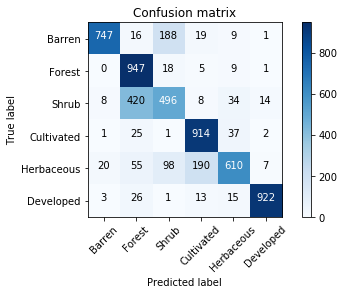

In [33]:
# Confusion matrix
y_pred = np.array(tf_df['predicted_label'])
y_true = np.array(tf_df['true_label'])
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [34]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.78843537415


In [35]:
# Accuracy (Undeveloped, Cultivated, Developed)

# Let 6 be a new label indicating undeveloped land as a whole
y_true[y_true==label_to_number_dict["Barren"]] = 6
y_true[y_true==label_to_number_dict["Forest"]] = 6
y_true[y_true==label_to_number_dict["Shrub"]] = 6
y_true[y_true==label_to_number_dict["Herbaceous"]] = 6

y_pred[y_pred==label_to_number_dict["Barren"]] = 6
y_pred[y_pred==label_to_number_dict["Forest"]] = 6
y_pred[y_pred==label_to_number_dict["Shrub"]] = 6
y_pred[y_pred==label_to_number_dict["Herbaceous"]] = 6

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.937244897959
